# HW3 : Math for Robotics

Author: Ruffin White  
Course: CSE291  
Date: Feb 23 2018

In [1]:
# Make plots inline
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
# set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('png')

# import modules for plotting and data analysis
import matplotlib.pyplot as plt

## 1. 

> Consider the following differential equation over the interval $(0,1]$:

$$
\frac{dy}{dx} = \frac{1}{x^2(1-y)}
$$

with $y(1)=-1$

* Obtain an exact analytical solution to the equation. In the following solve for $y(0)$ even though in theory the equation is not defined for $x=0$.
* Implement and use Eulers method to solve the differential equation numerically. Use a step size of $0.05$. How accurate is your numerical solution?
* Implement and use a fourth-order Runge-Kutta method to solve the differential equation numerically. Again, use a step size of $0.05$. Again, how accurate is your numerical solution?
* Implement and use a Richardson extrapolation to solve the equation, again with a step size of $0.05$. How accuracy is your solution compared to the analytical solution?

In [2]:
import re
import numpy as np

from scipy.integrate import ode
from scipy.integrate._ode import IntegratorBase

In [3]:
class MyIntegratorBase(IntegratorBase):
    def run(self, f, jac, y0, t0, t1, f_params, jac_params):
        y1, t, istate = self.runner(f, jac, y0, t0, t1, f_params, jac_params)
        self.istate = istate
        if istate < 0:
            unexpected_istate_msg = 'Unexpected istate={:d}'.format(istate)
            warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
                          self.messages.get(istate, unexpected_istate_msg)))
            self.success = 0
        return y1, t

def find_integrator(name):
    for cl in integrator_classes:
        if re.match(name, cl.__name__, re.I):
            return cl
    return None

class my_ode(ode):
    def set_integrator(self, name, **integrator_params):
        """
        Set integrator by name.
        Parameters
        ----------
        name : str
            Name of the integrator.
        integrator_params
            Additional parameters for the integrator.
        """
        integrator = find_integrator(name)
        if integrator is None:
            raise ValueError('No integrator name match with %r or is not available.' % name)
        else:
            self._integrator = integrator(**integrator_params)
            if not len(self._y):
                self.t = 0.0
                self._y = np.array([0.0], self._integrator.scalar)
            self._integrator.reset(len(self._y), self.jac is not None)
        return self

In [4]:
class euler(MyIntegratorBase):
    def __init__(self, **integrator_params):
        self.success = 1
        pass
    
    def runner(self, f, jac, y0, t0, t1, f_params, jac_params):
        y1 = y0 + jac(t0, y0, *jac_params) * (t1 - t0)
        
        istate = 0
        return y1, t1, istate

class rungekutta4(MyIntegratorBase):
    def __init__(self, **integrator_params):
        self.success = 1
        pass
    
    def runner(self, f, jac, y0, t0, t1, f_params, jac_params):
        h = t1-t0
        k_1 = jac((t0        ), (y0            ), *jac_params)
        k_2 = jac((t0 + 0.5*h), (y0 + 0.5*h*k_1), *jac_params)
        k_3 = jac((t0 + 0.5*h), (y0 + 0.5*h*k_2), *jac_params)
        k_4 = jac((t0 +     h), (y0 +     h*k_3), *jac_params)
        y1 = y0 + (h/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)
        
        istate = 0
        return y1, t1, istate

class richardson(MyIntegratorBase):
    def __init__(self, **integrator_params):
        self.success = 1
        pass
    
    def runner(self, f, jac, y0, t0, t1, f_params, jac_params):
        # richardson extrapolation  
        # http://www.math.ubc.ca/~feldman/m256/richard.pdf
        istate = 0
        return y1, t1, istate

integrator_classes = [euler, rungekutta4, richardson]

In [5]:
# https://www.khanacademy.org/math/ap-calculus-bc/bc-diff-equations/bc-eulers-method/v/eulers-method

y0, t0 = 1 , 0
# y0, t0 = -1 , 1

def f(t, y, arg1):
    return np.e**t
#     return 1 / (t * (y - 1))
def jac(t, y, arg1):
    return y
#     return 1 / (t**2 * (1 - y))

t1 = 1
# t1 = 0
dt = 0.0005

In [6]:
r = my_ode(f, jac).set_integrator(name='euler')
r.set_initial_value(y0, t0).set_f_params(None).set_jac_params(None)

while r.successful() and r.t < t1:
    t = r.t+dt
    y = r.integrate(t)

print("t: {0}, y: {1}".format(t, y))

t: 1.0004999999999453, y: [ 2.71896137]


In [7]:
r = my_ode(f, jac).set_integrator(name='rungekutta4')
r.set_initial_value(y0, t0).set_f_params(None).set_jac_params(None)

while r.successful() and r.t < t1:
    t = r.t+dt
    y = r.integrate(t)

print("t: {0}, y: {1}".format(t, y))

t: 1.0004999999999453, y: [ 2.71964131]


In [8]:
r = ode(f, jac).set_integrator(name='dopri5', method='adams', nsteps=10e4)
r.set_initial_value(y0, t0).set_f_params(None).set_jac_params(None)

while r.successful() and r.t < t1:
    t = r.t+dt
    y = r.integrate(t)

print("t: {0}, y: {1}".format(t, y))

t: 1.0004999999999453, y: [ 2.71964131]


## 2.

> Consider a predator-prey dynamics such as the simple Lotka-Volterra model

$$
x' = f(x)
$$

$$
x = 
\begin{pmatrix}
  x_1 \\
  x_2 \\
\end{pmatrix} =
\begin{pmatrix}
  Prey polution \\
  Predator Polution \\
\end{pmatrix}    
$$

$$
f(x) = 
\begin{pmatrix}
  (b-px_2)x_1 \\
  (rx_1 - d)x_2 \\
\end{pmatrix}   
$$

> Without predators, the prey population increases (exponentially) without bound, whereas without prey, the predator population diminishes (exponentially) to zero. The nonlinear interaction, with predators eating prey, tends to diminish the prey population and increase the predator population. Use your Runga-Kutta to solve this system, with the values $b = p = r = d = 1$, $x_1(0) = 0.3$, and $x_2(0) = 0.2$.

In [9]:
# http://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
y0, t0 = np.array([[0.3], [0.2]]), 0

b1 = 1
p1 = 1
r1 = 1
d1 = 1

def f(t, y, arg1):
    return 'foo'

def jac(t, y, b1, p1, r1, d1):
    y = np.array([(b1 - p1*y[1])*y[0],
                  (r1*y[0] - d1)*y[1]])
    return y

t1 = 15
dt = 0.0005

In [10]:
r = my_ode(f, jac).set_integrator(name='rungekutta4')
r.set_initial_value(y0, t0).set_f_params(None).set_jac_params(b1, p1, r1, d1)

ts = np.array([1])
ys = np.empty([2,1])

while r.successful() and r.t < t1:
    t = r.t+dt
    y = r.integrate(t)
    ts = np.append(ts, t)
    ys = np.append(ys, y, axis=1)

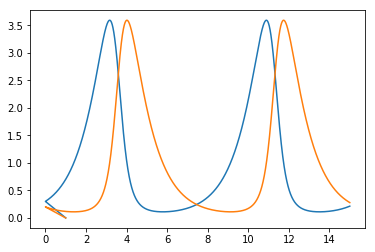

In [11]:
plt.plot(ts, ys.T)
plt.show()

## 3.

> We have multiple robots that can generate point clouds such as those coming from a Kinect camera. In many cases we want to use the robots to detect objects in its enviroment. We provide three data files:

(a) Empty-Table.txt which containts a data for an empty table  
(b) Cluttered-Table.txt contains point cloud for a cluttered table  
(c) Hallway.txt  

> Each file has the point cloud file in a format with each line contains $x_i y_i z_i$

* Provide a method to estimate the plane parameter for the table. Test it both with the empty and cluttered table. Describe how you filter out the data from the objects. You have to be able to estimate the table parameters in the presence of clutter.
* Describe and show how the method can be generalized to extract all the dominant planes in a relatively empty hallway.